# <span style="color:#000033;font-size:28px;text-align: center;"><center>**FAKE PROFILE DETECTION USING RANDOM FOREST AND SVM**</center> </span>

### Importing the libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install gender_guesser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gender_guesser.detector as gender
from urllib.parse import urlparse
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
import warnings
warnings.filterwarnings('ignore')

### Concatenating the fake and genuine user datasets

In [ ]:
users=pd.read_csv('/content/drive/MyDrive/2. SIN PROJ/users.csv') ## genuine users
fusers=pd.read_csv('/content/drive/MyDrive/2. SIN PROJ/fusers.csv') ## fake users
l1=users.shape[0]
df=pd.concat([users,fusers],ignore_index=True)
df.loc[:l1-1,'fake']=0
df.loc[l1:,'fake']=1
df['fake']=df['fake'].astype('int')

### Function for predicting sex using name of person

In [ ]:
d = gender.Detector()
sex=df['name'].apply(lambda x:d.get_gender(x.split()[0].capitalize()))
prev=sex.value_counts()
sexdict={'female':-2,'mostly_female':-1,'andy':0,'unknown':0,'mostly_male':1,'male':2}
df['sex']=sex.map(sexdict)

### Understanding the variables

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2818 entries, 0 to 2817
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  2818 non-null   int64  
 1   name                                2818 non-null   object 
 2   screen_name                         2818 non-null   object 
 3   statuses_count                      2818 non-null   int64  
 4   followers_count                     2818 non-null   int64  
 5   friends_count                       2818 non-null   int64  
 6   favourites_count                    2818 non-null   int64  
 7   listed_count                        2818 non-null   int64  
 8   created_at                          2818 non-null   object 
 9   url                                 463 non-null    object 
 10  lang                                2818 non-null   object 
 11  time_zone                           1069 no

In [ ]:
df['created_at']=pd.to_datetime(df['created_at'])

In [ ]:
df['created_at_year']=df['created_at'].dt.year
df['created_at_month']=df['created_at'].dt.month
df.drop('created_at',axis=1,inplace=True)

In [ ]:
df.drop('updated',axis=1,inplace=True)

In [ ]:
df.head()

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,url,lang,...,profile_link_color,utc_offset,protected,verified,description,dataset,fake,sex,created_at_year,created_at_month
0,3610511,Davide Dellacasa,braddd,20370,5470,2385,145,52,http://braddd.tumblr.com,it,...,FF0000,3600.0,NaN,NaN,Founder of http://www.screenweek.it & http://w...,E13,0,2,2007,4
1,5656162,Simone Economo,eKoeS,3131,506,381,9,40,http://www.lineheight.net/,en,...,0084B4,3600.0,NaN,NaN,BSc degree (cum laude) in Computer Engineering...,E13,0,-2,2007,4
2,5682702,tacone,tacone_,4024,264,87,323,16,http://t.co/LKrl1dZE,en,...,2FC2EF,3600.0,NaN,NaN,Cogito ergo bestemmio.,E13,0,0,2007,5
3,6067292,alesaura,alesstar,40586,640,622,1118,32,http://alesstar.wordpress.com/,en,...,0099B9,3600.0,NaN,NaN,"Se la vita ti dà sarde, scapocciale!",E13,0,0,2007,5
4,6015122,Angelo,PerDiletto,2016,62,64,13,0,http://www.flickr.com/per_diletto,it,...,038543,3600.0,NaN,NaN,Je me souviens,E13,0,2,2007,5


In [ ]:
df.shape

(2818, 36)

### Data Cleaning

In [ ]:
ms_cols=df.isnull().mean()*100
ms_cols=ms_cols.sort_values(ascending=False)
ms_cols

verified                              100.000000
protected                             100.000000
default_profile_image                  99.716111
url                                    83.569908
profile_background_tile                82.647268
geo_enabled                            74.414478
profile_banner_url                     64.975160
time_zone                              62.065295
utc_offset                             62.065295
default_profile                        38.679915
location                               19.410930
description                             9.616749
profile_use_background_image            2.058197
profile_background_image_url            0.000000
profile_background_color                0.000000
profile_link_color                      0.000000
id                                      0.000000
dataset                                 0.000000
fake                                    0.000000
sex                                     0.000000
created_at_year     

In [ ]:
null_cols=ms_cols[ms_cols>90].index
df.drop(null_cols,axis=1,inplace=True)

<AxesSubplot:>

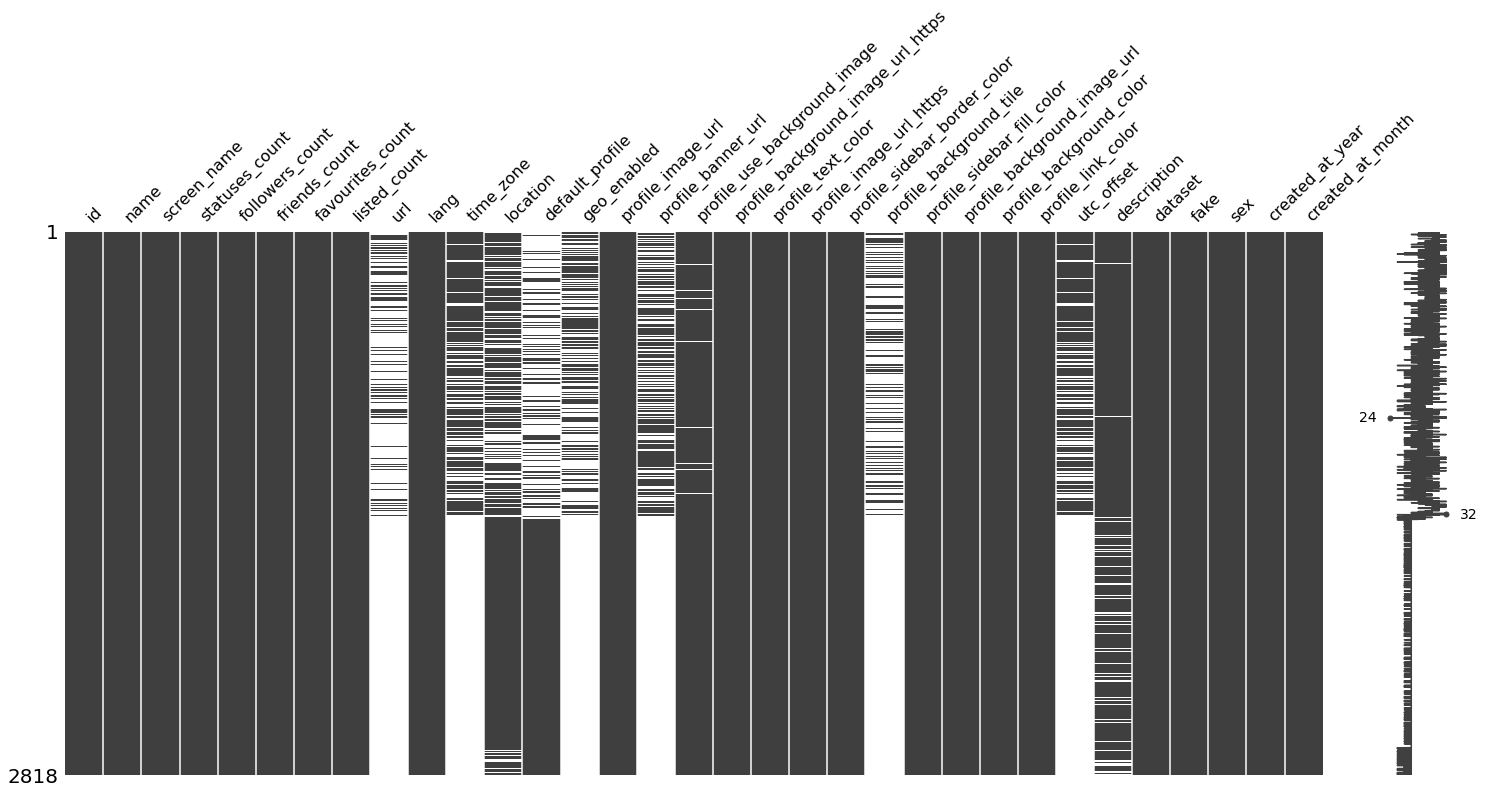

In [ ]:
import missingno as msno
msno.matrix(df)

<AxesSubplot:>

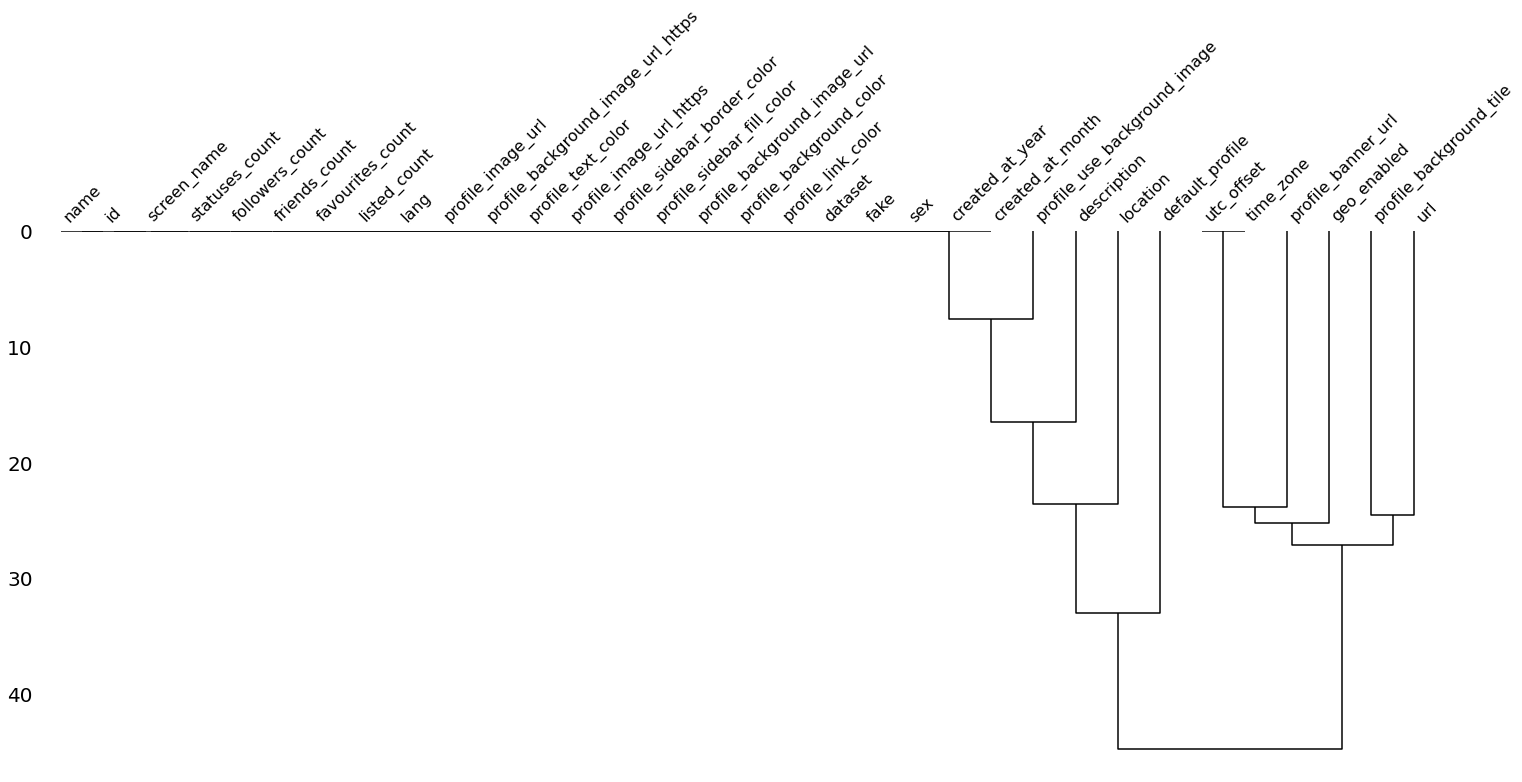

In [ ]:
msno.dendrogram(df)

In [ ]:
ms_cols[np.logical_and(ms_cols>0,ms_cols<90)]

url                             83.569908
profile_background_tile         82.647268
geo_enabled                     74.414478
profile_banner_url              64.975160
time_zone                       62.065295
utc_offset                      62.065295
default_profile                 38.679915
location                        19.410930
description                      9.616749
profile_use_background_image     2.058197
dtype: float64

In [ ]:
ms_cols=ms_cols[np.logical_and(ms_cols>0,ms_cols<90)].index
df[ms_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2818 entries, 0 to 2817
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   url                           463 non-null    object 
 1   profile_background_tile       489 non-null    float64
 2   geo_enabled                   721 non-null    float64
 3   profile_banner_url            987 non-null    object 
 4   time_zone                     1069 non-null   object 
 5   utc_offset                    1069 non-null   float64
 6   default_profile               1728 non-null   float64
 7   location                      2271 non-null   object 
 8   description                   2547 non-null   object 
 9   profile_use_background_image  2760 non-null   float64
dtypes: float64(5), object(5)
memory usage: 220.3+ KB


### Handling Missing Values of Categorical Fetaures

In [ ]:
df['url'].fillna("Missing",inplace=True)
df['profile_banner_url'].fillna("Missing",inplace=True)
df['time_zone'].fillna("Missing",inplace=True)
df['location'].fillna("Missing",inplace=True)
df['description'].fillna("Missing",inplace=True)

### Handling Missing Values of Numerical Fetaures

In [ ]:
df['default_profile'].value_counts(dropna=False,normalize=True)

1.0    0.613201
NaN    0.386799
Name: default_profile, dtype: float64

In [ ]:
df['profile_background_tile'].value_counts(dropna=False,normalize=True)

NaN    0.826473
1.0    0.173527
Name: profile_background_tile, dtype: float64

In [ ]:
df['geo_enabled'].value_counts(dropna=False,normalize=True)

NaN    0.744145
1.0    0.255855
Name: geo_enabled, dtype: float64

In [ ]:
df['profile_use_background_image'].value_counts(dropna=False,normalize=True)

1.0    0.979418
NaN    0.020582
Name: profile_use_background_image, dtype: float64

#### As we can see all the numerical columns except utc_offset have only binary values replacing Nan values by 0

In [ ]:
df['default_profile'].fillna(0,inplace=True)
df['profile_background_tile'].fillna(0,inplace=True)
df['geo_enabled'].fillna(0,inplace=True)
df['profile_use_background_image'].fillna(0,inplace=True)

In [ ]:
df['utc_offset'].value_counts(dropna=False,normalize=True)

 NaN        0.620653
 3600.0     0.275018
 7200.0     0.045422
-10800.0    0.034776
-36000.0    0.008872
 0.0        0.007807
-18000.0    0.001774
 14400.0    0.001065
-25200.0    0.001065
 19800.0    0.001065
-39600.0    0.000710
-28800.0    0.000710
 36000.0    0.000355
 12600.0    0.000355
-21600.0    0.000355
Name: utc_offset, dtype: float64

In [ ]:
pip install missingpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
numericCols=df._get_numeric_data().columns
numericCols
imputer=MissForest()
utc_offset=df['utc_offset'].copy()
df[numericCols]=imputer.fit_transform(df[numericCols])

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


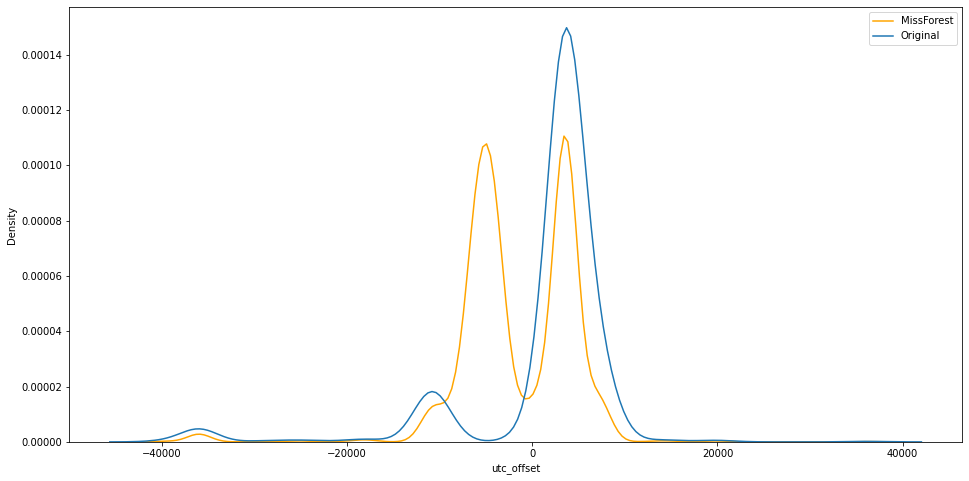

In [ ]:
plt.figure(figsize=(16,8))
sns.kdeplot(df['utc_offset'],color='Orange')
sns.kdeplot(utc_offset)
plt.legend(['MissForest','Original'])

In [ ]:
df.isnull().sum().sum()

0

### Data Visualization

<AxesSubplot:xlabel='fake', ylabel='count'>

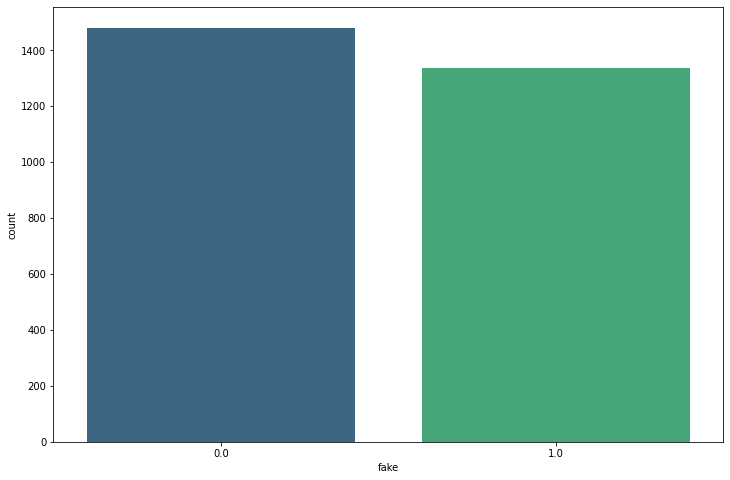

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(df['fake'],palette='viridis')

<AxesSubplot:xlabel='sex', ylabel='count'>

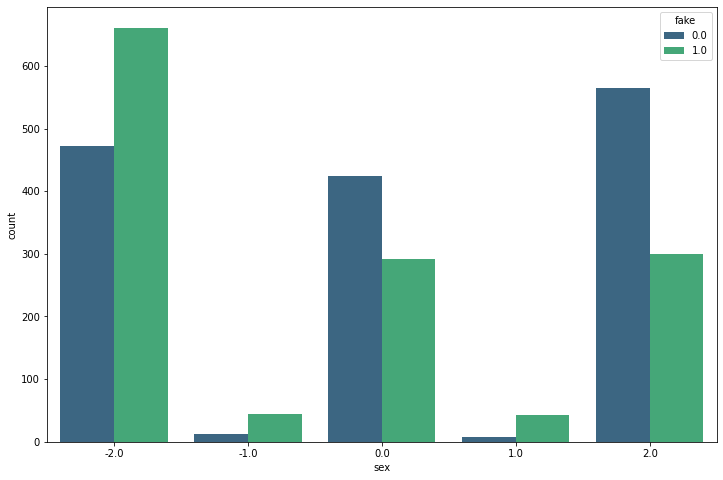

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(df['sex'],hue=df['fake'],palette='viridis')

value_counts
fake  lang              
False it            1297
      en             166
      es              10
      fr               3
      de               2
      gl               1
      nl               1
      tr               1
True  en            1336
      es               1

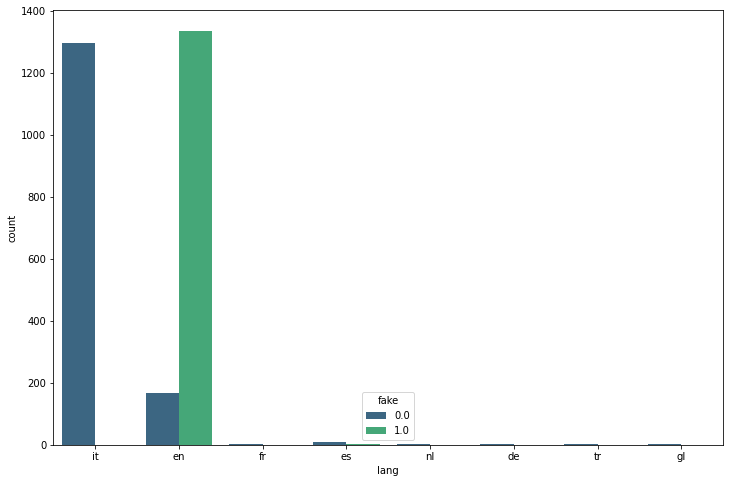

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(df['lang'],hue=df['fake'],palette='viridis')
lg=pd.DataFrame(df.groupby(df['fake']==1)['lang'].value_counts())
lg.columns=['value_counts']
lg

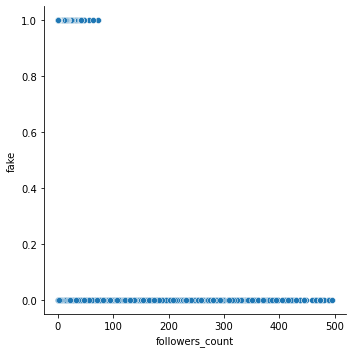

In [ ]:
ind=df[df.followers_count<500].index
sns.relplot(df.loc[df.followers_count<500,'followers_count'],df.loc[ind,'fake'],palette='viridis')

Text(0.5, 1.0, 'Status Count vs Fake')

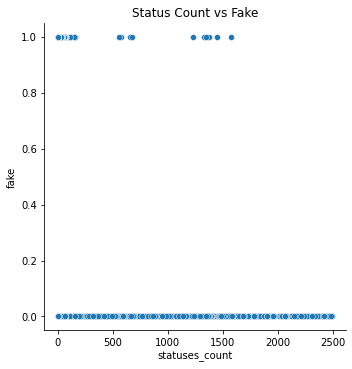

In [ ]:
ind=df[df.statuses_count<2500].index
sns.relplot(df.loc[df.statuses_count<2500,'statuses_count'],df.loc[ind,'fake'],palette='viridis')
plt.title("Status Count vs Fake")

<AxesSubplot:xlabel='time_zone', ylabel='count'>

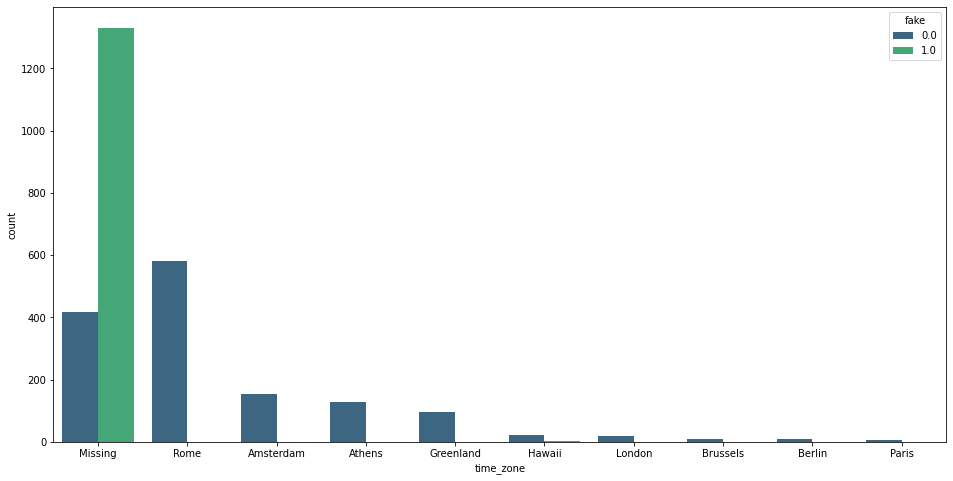

In [ ]:
plt.figure(figsize=(16,8))
sns.countplot(df['time_zone'],hue=df["fake"],order=df.time_zone.value_counts().head(10).index,palette='viridis')

### Feature Engineering

In [ ]:
df1=df.copy()

In [ ]:
catCols=[x for x in df.columns if x not in numericCols]
for i in catCols:
    print(i,len(df[i].unique()))

name 2811
screen_name 2818
url 463
lang 8
time_zone 34
location 1679
profile_image_url 2815
profile_banner_url 988
profile_background_image_url_https 770
profile_text_color 180
profile_image_url_https 2815
profile_sidebar_border_color 128
profile_sidebar_fill_color 179
profile_background_image_url 759
profile_background_color 273
profile_link_color 365
description 2537
dataset 2


In [ ]:
df.groupby("url")["fake"].value_counts()

url                                                                    fake
Missing                                                                1.0     1337
                                                                       0.0     1018
http://AvevoDiversiBlogMaLiHoCancellatiNonAvendoliMaiResiPubblici.com  0.0        1
http://a.tumblr.com/tumblr_lsacvi0Jf81qkdlzoo1.mp3                     0.0        1
http://a24fotogrammi.wordpress.com/                                    0.0        1
                                                                               ... 
https://www.facebook.com/laura.trudu                                   0.0        1
https://www.facebook.com/profile.php?id=708260739                      0.0        1
https://www.facebook.com/sofia.gazzotti                                0.0        1
https://www.facebook.com/stefano.biasiucci                             0.0        1
https://www.facebook.com/storieinaffitto                               0.0        1


In [ ]:
df["fake"].value_counts()

0.0    1481
1.0    1337
Name: fake, dtype: int64

1. All the fake accounts don't have an url .So there is no use of the column <b>url</b>. Hence we will be removing that column.
2. The columns <b>name, description</b> and <b>screen_name</b> have only unique values in it. Hence removing those columns also. Instead we will be keeping <b>id</b> column in the dataset.
3. The columns <b>profile_image_url,profile_banner_url,profile_background_image_url_https,profile_text_color,profile_image_url_https ,profile_sidebar_border_color,profile_sidebar_fill_color,profile_background_image_url,profile_background_color,profile_link_color</b> are needed for Neural Network models. As far as Random Forest and SVM are considered we won't be needing those columns.
4. As far the column <b>time zone</b> is considered we have it's equivalent numerical column utc_offset. Hence we will remove time zone also.

In [ ]:
df.shape

(2818, 33)

In [ ]:
df['lang'].value_counts()

en    1502
it    1297
es      11
fr       3
de       2
nl       1
tr       1
gl       1
Name: lang, dtype: int64

In [ ]:
ind=df['lang'].value_counts().index
df['lang_code']=df['lang'].map({k:i for i,k in enumerate(ind)})

In [ ]:
df.head()

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,url,lang,...,profile_background_color,profile_link_color,utc_offset,description,dataset,fake,sex,created_at_year,created_at_month,lang_code
0,3610511.0,Davide Dellacasa,braddd,20370.0,5470.0,2385.0,145.0,52.0,http://braddd.tumblr.com,it,...,BADFCD,FF0000,3600.0,Founder of http://www.screenweek.it & http://w...,E13,0.0,2.0,2007.0,4.0,1
1,5656162.0,Simone Economo,eKoeS,3131.0,506.0,381.0,9.0,40.0,http://www.lineheight.net/,en,...,C0DEED,0084B4,3600.0,BSc degree (cum laude) in Computer Engineering...,E13,0.0,-2.0,2007.0,4.0,0
2,5682702.0,tacone,tacone_,4024.0,264.0,87.0,323.0,16.0,http://t.co/LKrl1dZE,en,...,1A1B1F,2FC2EF,3600.0,Cogito ergo bestemmio.,E13,0.0,0.0,2007.0,5.0,0
3,6067292.0,alesaura,alesstar,40586.0,640.0,622.0,1118.0,32.0,http://alesstar.wordpress.com/,en,...,0099B9,0099B9,3600.0,"Se la vita ti dà sarde, scapocciale!",E13,0.0,0.0,2007.0,5.0,0
4,6015122.0,Angelo,PerDiletto,2016.0,62.0,64.0,13.0,0.0,http://www.flickr.com/per_diletto,it,...,ACDED6,038543,3600.0,Je me souviens,E13,0.0,2.0,2007.0,5.0,1


In [ ]:
X=[x for x in df.columns if x not in catCols]
X=df[X]
X=X.drop('fake',axis=1)
y=df['fake']

In [ ]:
X.drop(['profile_use_background_image', 'profile_background_tile','default_profile'],axis=1,inplace=True)

In [ ]:
X['geo_enabled'].value_counts()

0.0    2097
1.0     721
Name: geo_enabled, dtype: int64

In [ ]:
X.shape

(2818, 12)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2818 entries, 0 to 2817
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                2818 non-null   float64
 1   statuses_count    2818 non-null   float64
 2   followers_count   2818 non-null   float64
 3   friends_count     2818 non-null   float64
 4   favourites_count  2818 non-null   float64
 5   listed_count      2818 non-null   float64
 6   geo_enabled       2818 non-null   float64
 7   utc_offset        2818 non-null   float64
 8   sex               2818 non-null   float64
 9   created_at_year   2818 non-null   float64
 10  created_at_month  2818 non-null   float64
 11  lang_code         2818 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 264.3 KB


### Feature Selection

In [ ]:
df1=pd.concat([X,y],axis=1)

<AxesSubplot:>

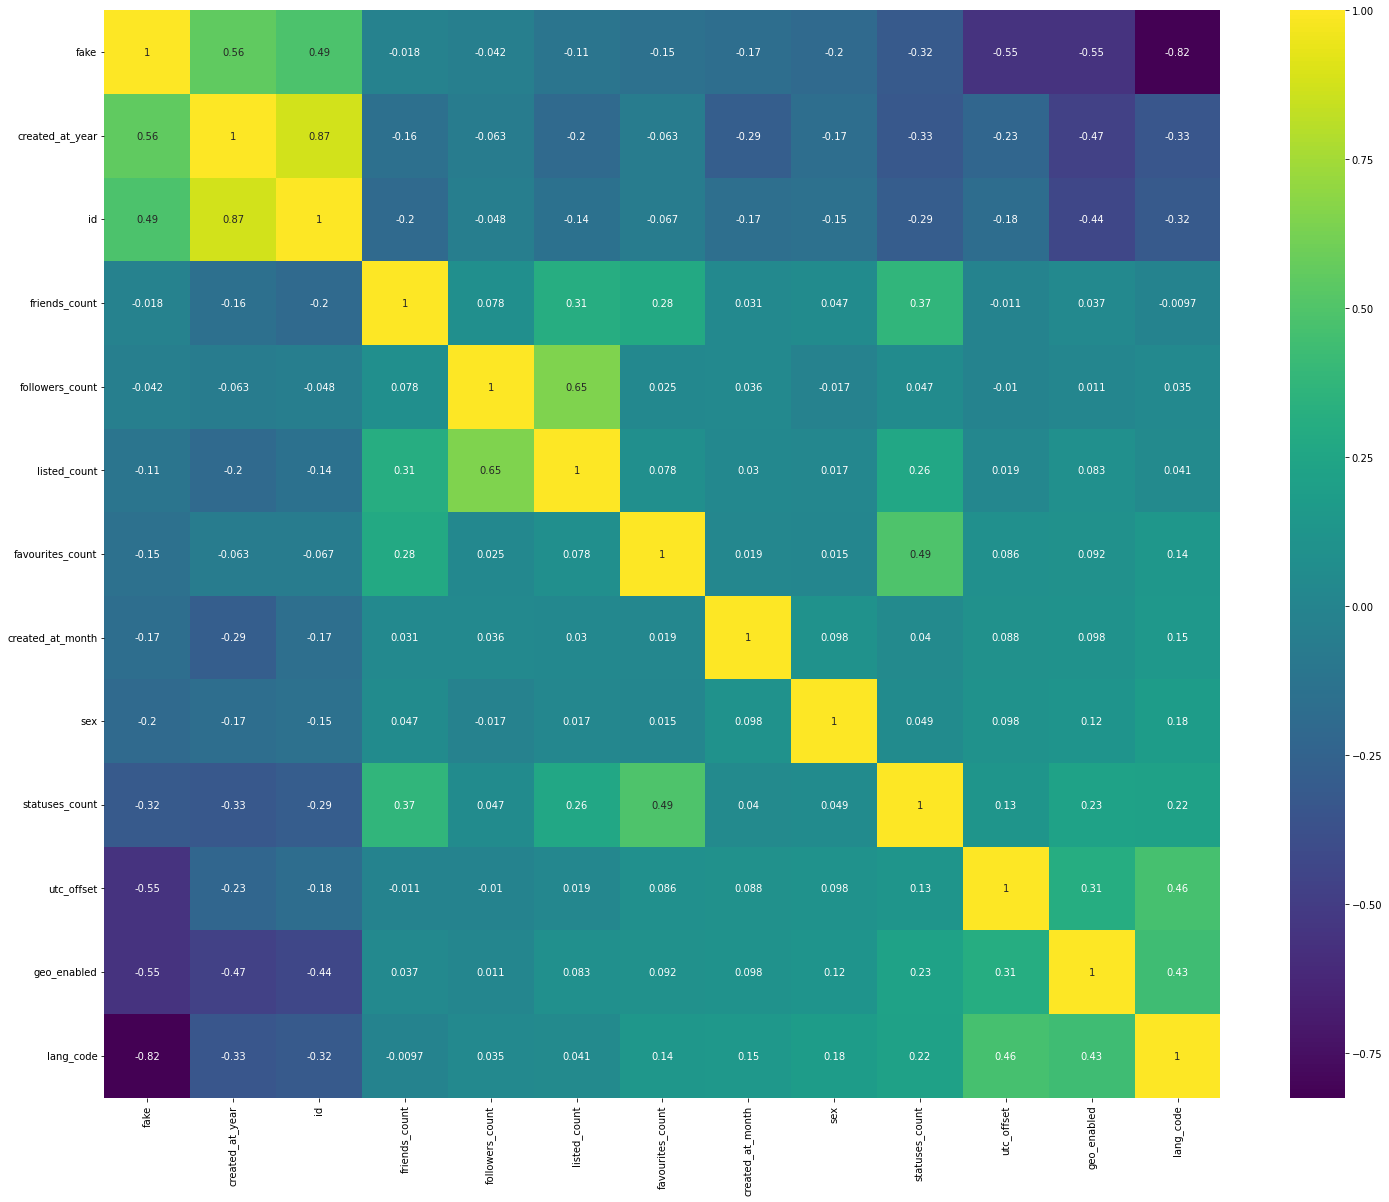

In [ ]:
target='fake'
plt.figure(figsize=(25,20))
cols=df1[df1.corr().nlargest(13,target)[target].index].corr()
sns.heatmap(cols,annot=True,cmap='viridis')

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=500,criterion='entropy',max_depth=2,random_state=15)
model=RFECV(estimator=rfc,cv=5,scoring="accuracy",n_jobs=-1)
model.fit(X,y)
print(model.ranking_)
mask=model.get_support()
cols=X.columns.to_numpy()
bestfeats=cols[mask]
bestfeats

[1 1 1 1 1 1 2 1 4 1 3 1]


array(['id', 'statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'utc_offset',
       'created_at_year', 'lang_code'], dtype=object)

In [ ]:
notall=[x for x in X.columns if x not in bestfeats]
notall

['geo_enabled', 'sex', 'created_at_month']

In [ ]:
X=df[list(bestfeats)]
X.columns  ## Feature allowed to use

Index(['id', 'statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'utc_offset', 'created_at_year',
       'lang_code'],
      dtype='object')

### Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0,stratify=y)

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=500,random_state=15)
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=500, random_state=15)

In [ ]:
y_pred=rfc.predict(X_test)
pd.Series(y_pred).value_counts()

0.0    447
1.0    399
dtype: int64

In [ ]:
y_test.value_counts()

0.0    445
1.0    401
Name: fake, dtype: int64

<AxesSubplot:xlabel='fake'>

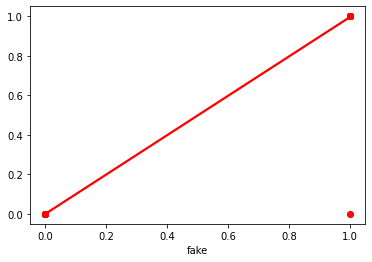

In [ ]:
sns.regplot(y_test,y_pred,ci=None,color='red')

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       445
         1.0       1.00      1.00      1.00       401

    accuracy                           1.00       846
   macro avg       1.00      1.00      1.00       846
weighted avg       1.00      1.00      1.00       846



Confusion matrix
[[445   0]
 [  2 399]]


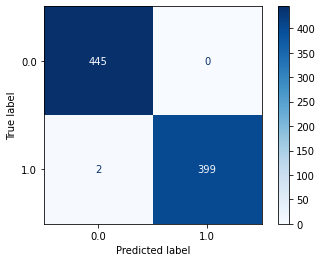

In [ ]:
cm=confusion_matrix(y_test,y_pred)
print('Confusion matrix')
print(cm)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_).plot(cmap=plt.cm.Blues)
plt.grid(False)

In [ ]:
print("Accuracy :",rfc.score(X_test,y_test)*100)

Accuracy : 99.76359338061465


### SVM

### Data Preprocessing (Scaler)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
from sklearn.svm import SVC
svc=SVC(kernel='rbf',random_state=15)
svc.fit(X_train,y_train)

SVC(random_state=15)

In [ ]:
y_pred=svc.predict(X_test)
pd.Series(y_pred).value_counts()

0.0    446
1.0    400
dtype: int64

<AxesSubplot:xlabel='fake'>

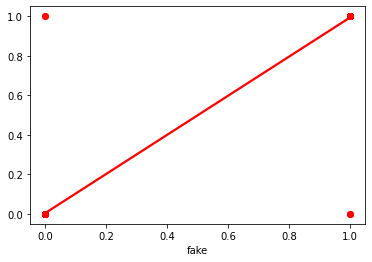

In [ ]:
sns.regplot(y_test,y_pred,ci=None,color='red')

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       445
         1.0       0.99      0.99      0.99       401

    accuracy                           0.99       846
   macro avg       0.99      0.99      0.99       846
weighted avg       0.99      0.99      0.99       846



Confusion matrix
[[443   2]
 [  3 398]]


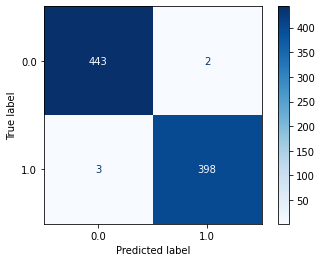

In [ ]:
cm=confusion_matrix(y_test,y_pred)
print('Confusion matrix')
print(cm)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_).plot(cmap=plt.cm.Blues)
plt.grid(False)

In [ ]:
print("Accuracy :",svc.score(X_test,y_test)*100)

Accuracy : 99.40898345153664


### Conclusion
1. Most of the profiles that were fake were mostly female .This indicates that  fraudsters create fake profiles as beautiful women with the intention of making people fall for the scam.
2. The fake profiles used either English or Spanish languages.
3. Fake profiles had  a followers count ranging between 0 and 100. This indicates that profiles who had more followers count were genuine. One can easily identify whether a profile is fake or not depending on the followers count.
4. Most of the fake profiles didn't mention their time zones. This is due to the reason that  the absence of time zone or location information can make it more difficult to verify the identity of someone online.
5. Most of the fake profiles had a minimum status count. This indicates that profiles that had more status counts were genuine.